In [1]:
import networkx as nx
import string
import matplotlib.pyplot as plt
import osmnx as ox
import pandas as pd

useful_tags_path = ['bridge', 'tunnel', 'oneway', 'lanes', 'ref', 'name', 'length',
                    'highway', 'maxspeed', 'service', 'access', 'area', 'name'
                    'landuse', 'width', 'est_width', 'junction', 'surface']
ox.settings.useful_tags_way=useful_tags_path

def generate_streetnetwork():

    """
    Load a network from OSMNX which will be used for the simulation runs. The generated network is from Rotterdam.
    Returns
    -------
    G: network MultiGraph
        Network Graph with different attributes:
            Nodes and Edges with LineString with coordinates,
            Edges have properties Speed, Travel time, Length.

    """
    lonlat=     'Netherlands'                                 #coordinates of the city centre of Rotterdam
    roadtype=   "drive"                                     #select only roads which are driveable by the car.

    # cf = '["highway"~"motorway|motorway_link"]'
    # cf = '["highway"~"primary"]'  # orange roads OSM viewer
    # cf = '["highway"~"motorway|motorway_link|primary|secondary"]'
    cf = '["highway"~"motorway|motorway_link|trunk|trunk_link|primary|secondary|tertiary|residential"]'

    ox.settings.log_console=True
    ox.settings.use_cache=True
    # ox.config(use_cache=True, log_console=True)

    # download street network data from OSM and construct a MultiDiGraph model
    # G = ox.graph_from_address('Emmerich, Germany', dist=10000, simplify=True, custom_filter=cf)
    G = ox.graph_from_address('Union Square, New York, United States', dist=5000, network_type='drive', simplify=True, custom_filter=cf)

    # G = ox.graph_from_place('Almelo, Netherlands', network_type='drive', simplify=True, custom_filter=cf)

    # default speeds
    hwy_speeds = {'motorway': 100,
                    'trunk': 100,
                    'residential': 30,
                    'tertiary': 30} #etc

    G = ox.add_edge_speeds(G, hwy_speeds=hwy_speeds)
    G = ox.add_edge_travel_times(G, precision=1)

    return G

In [2]:
def save_graph(G):
    filepath=f"graphs/Manhattan.graph.graphml"
    # ox.save_graph_geopackage(G, filepath=filepath)
    ox.save_graphml(G,filepath)

In [3]:
def draw_edges(graph):
    edges_fugitive = []

    # for i_r, route_time in enumerate(fugitive_routes):
    #     route = list(route_time.values())
    #     for i, node in enumerate(route):
    #         if i ==0:
    #             continue
    #         else:
    #             edges_fugitive1 = [(route[i], route[i-1])]
    #             edges_fugitive2 = [(route[i-1], route[i])]
    #             edges_fugitive.extend(tuple(edges_fugitive1))
    #             edges_fugitive.extend(tuple(edges_fugitive2))

    edge_colormap = ['silver'] * len(graph.edges())
    edge_weightmap = [1] * len(graph.edges())
    for index, edge in enumerate(graph.edges()):
        if edge in edges_fugitive:
            edge_colormap[index] = 'tab:orange'
            edge_weightmap[index] = 2

    return edge_colormap, edge_weightmap

In [4]:
# city = ("")
# distance = 2400
#
G=generate_streetnetwork()
# save_graph(G, city, distance)
#
# print(len(G.nodes()))

# show_graph(city, distance)

C:\Users\isvandroffelaa\AppData\Local\Temp\ipykernel_3852\3184517092.py:49: UserWarning: the `precision` parameter is deprecated and will be removed in a future release
  G = ox.add_edge_travel_times(G, precision=1)


In [5]:
save_graph(G)

In [6]:
def show_graph():
    # filepath=f"graphs/FLEE/Graph_FLEE.graph.graphml"
    # G = ox.load_graphml(filepath=filepath)

    config = 3

    edge_colormap, edge_weightmap = draw_edges(G)
    suspect_start = ox.nearest_nodes(G, -73.98959647256116, 40.73585784808693)  # union square

    node_size = []
    node_color = []
    for node in G.nodes:
        if node == suspect_start:
            node_size.append(40)
            node_color.append('red')
        else:
            node_size.append(0)
            node_color.append('silver')

    fig, ax = ox.plot_graph(
                G, bgcolor="white", node_color=node_color, node_size=node_size, edge_linewidth=edge_weightmap, edge_color=edge_colormap,
                save=True, filepath=f'graphs/prelim_Manhattan.png'
                )
    # ax.savefig('graphs/FLEE/Graph_FLEE.png')

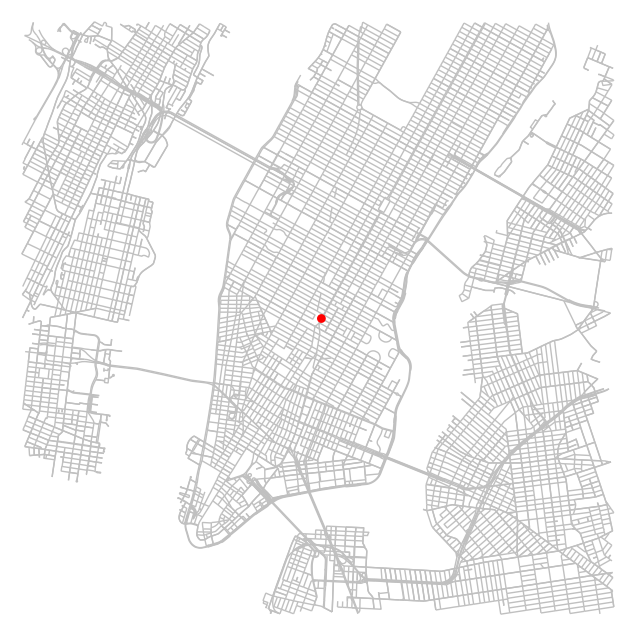

In [7]:
show_graph()

In [8]:
len(G.nodes())

5987

## Find border nodes

In [9]:
import geopandas as gpd
import shapely

filepath=f"graphs/Manhattan.graph.graphml"
G = ox.load_graphml(filepath=filepath)

In [10]:
nodes_gdf, streets = ox.graph_to_gdfs(G, nodes=True, edges=True,
                            node_geometry=False, fill_edge_geometry=True)
streets = streets.to_crs(4326)
streets

osmid                name  \
u           v           key                                              
42421828    42430942    0                194923763    East 10th Street   
            42430938    0                194923763    East 10th Street   
42421877    42421889    0    [5668989, 1032454983]     West 9th Street   
            42437949    0                889114527          5th Avenue   
42421889    42432191    0                 24264114  Christopher Street   
...                                            ...                 ...   
11496014207 11496014189 0               1238545752              Bowery   
11543660372 1632878962  0               1242277191    East 28th Street   
11543660390 1632878885  0                829073006    East 27th Street   
11659009136 42436014    0                 46139040       Hudson Street   
            42436017    0    [5670418, 1254245253]   Desbrosses Street   

                                 highway maxspeed          surface  oneway  \
u           v           key                                                  
42421828    42430942    0       tertiary   20 mph          asphalt   False   
            42430938    0       tertiary   20 mph          asphalt   False   
42421877    42421889    0    residential   25 mph          asphalt    True   
            42437949    0      secondary   25 mph          asphalt    True   
42421889    42432191    0    residential   25 mph          asphalt    True   
...                                  ...      ...              ...     ...   
11496014207 11496014189 0        primary   25 mph          asphalt   False   
11543660372 1632878962  0    residential   25 mph          asphalt   False   
11543660390 1632878885  0    residential   25 mph              NaN   False   
11659009136 42436014    0          trunk   25 mph          asphalt    True   
            42436017    0    residential   25 mph  [asphalt, sett]    True   

                            reversed   length  \
u           v           key                     
42421828    42430942    0      False  101.450   
            42430938    0       True  127.633   
42421877    42421889    0      False  311.336   
            42437949    0      False   76.599   
42421889    42432191    0      False   41.444   
...                              ...      ...   
11496014207 11496014189 0       True   42.868   
11543660372 1632878962  0      False  108.737   
11543660390 1632878885  0      False   60.553   
11659009136 42436014    0      False    5.707   
            42436017    0      False  131.760   

                                                                      geometry  \
u           v           key                                                      
42421828    42430942    0    LINESTRING (-73.97621 40.72533, -73.97527 40.7...   
            42430938    0    LINESTRING (-73.97621 40.72533, -73.97737 40.7...   
42421877    42421889    0    LINESTRING (-73.99593 40.73286, -73.99603 40.7...   
            42437949    0    LINESTRING (-73.99593 40.73286, -73.99596 40.7...   
42421889    42432191    0    LINESTRING (-73.99918 40.73415, -73.99936 40.7...   
...                                                                        ...   
11496014207 11496014189 0    LINESTRING (-73.99606 40.71627, -73.99602 40.7...   
11543660372 1632878962  0    LINESTRING (-73.97467 40.73953, -73.97449 40.7...   
11543660390 1632878885  0    LINESTRING (-73.97476 40.73847, -73.97467 40.7...   
11659009136 42436014    0    LINESTRING (-74.00802 40.72323, -74.00801 40.7...   
            42436017    0    LINESTRING (-74.00802 40.72323, -74.00803 40.7...   

                             speed_kph  travel_time   lanes      access  ref  \
u           v           key                                                    
42421828    42430942    0         32.2         11.3     NaN         NaN  NaN   
            42430938    0         32.2         14.3     NaN         NaN  NaN   
42421877    42421889    0         40.2    

In [11]:
# import geopackage file in geopandas
mh = gpd.read_file("geodata/manhattan-island_1372.geojson")
# nld = gpd.read_file("graphs/FLEE/Netherlands_shapefile/nl_1km.shp")
mh = mh.to_crs(4326)
mh

,type,id,tags,relations,meta,name,geometry
0,relation,3954665,"{'alt_name:ru': 'сотров Манхаттан', 'area': 'y...",[ ],{},Manhattan Island,"POLYGON ((-73.93019 40.79460, -73.93010 40.794..."


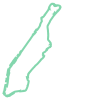

In [12]:
multiLines = mh.geometry[0].exterior
multiLines

In [13]:
lines = streets.geometry.unary_union
intersection = lines.intersection(mh.geometry[0])
# [p for p in intersection.geoms]
type(intersection)

shapely.geometry.multilinestring.MultiLineString

In [14]:
intersectionn = gpd.sjoin(streets, mh)

<Axes: >

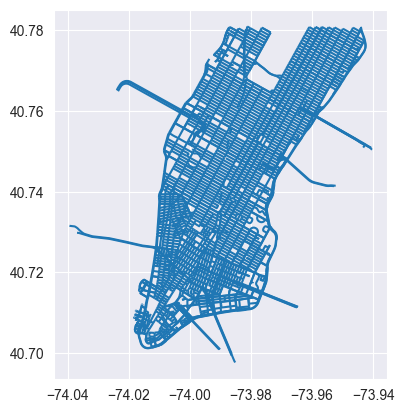

In [15]:
intersectionn.plot()

In [16]:
intersectionn

osmid           name_left  \
u           v           key                                              
42421828    42430942    0                194923763    East 10th Street   
            42430938    0                194923763    East 10th Street   
42421877    42421889    0    [5668989, 1032454983]     West 9th Street   
            42437949    0                889114527          5th Avenue   
42421889    42432191    0                 24264114  Christopher Street   
...                                            ...                 ...   
11496014207 11496014189 0               1238545752              Bowery   
11543660372 1632878962  0               1242277191    East 28th Street   
11543660390 1632878885  0                829073006    East 27th Street   
11659009136 42436014    0                 46139040       Hudson Street   
            42436017    0    [5670418, 1254245253]   Desbrosses Street   

                                 highway maxspeed          surface  oneway  \
u           v           key                                                  
42421828    42430942    0       tertiary   20 mph          asphalt   False   
            42430938    0       tertiary   20 mph          asphalt   False   
42421877    42421889    0    residential   25 mph          asphalt    True   
            42437949    0      secondary   25 mph          asphalt    True   
42421889    42432191    0    residential   25 mph          asphalt    True   
...                                  ...      ...              ...     ...   
11496014207 11496014189 0        primary   25 mph          asphalt   False   
11543660372 1632878962  0    residential   25 mph          asphalt   False   
11543660390 1632878885  0    residential   25 mph              NaN   False   
11659009136 42436014    0          trunk   25 mph          asphalt    True   
            42436017    0    residential   25 mph  [asphalt, sett]    True   

                            reversed   length  \
u           v           key                     
42421828    42430942    0      False  101.450   
            42430938    0       True  127.633   
42421877    42421889    0      False  311.336   
            42437949    0      False   76.599   
42421889    42432191    0      False   41.444   
...                              ...      ...   
11496014207 11496014189 0       True   42.868   
11543660372 1632878962  0      False  108.737   
11543660390 1632878885  0      False   60.553   
11659009136 42436014    0      False    5.707   
            42436017    0      False  131.760   

                                                                      geometry  \
u           v           key                                                      
42421828    42430942    0    LINESTRING (-73.97621 40.72533, -73.97527 40.7...   
            42430938    0    LINESTRING (-73.97621 40.72533, -73.97737 40.7...   
42421877    42421889    0    LINESTRING (-73.99593 40.73286, -73.99603 40.7...   
            42437949    0    LINESTRING (-73.99593 40.73286, -73.99596 40.7...   
42421889    42432191    0    LINESTRING (-73.99918 40.73415, -73.99936 40.7...   
...                                                                        ...   
11496014207 11496014189 0    LINESTRING (-73.99606 40.71627, -73.99602 40.7...   
11543660372 1632878962  0    LINESTRING (-73.97467 40.73953, -73.97449 40.7...   
11543660390 1632878885  0    LINESTRING (-73.97476 40.73847, -73.97467 40.7...   
11659009136 42436014    0    LINESTRING (-74.00802 40.72323, -74.00801 40.7...   
            42436017    0    LINESTRING (-74.00802 40.72323, -74.00803 40.7...   

                             speed_kph  ...  width junction service  \
u           v           key             ...                           
42421828    42430942    0         32.2  ...    NaN      NaN     NaN   
            42430938    0         32.2  ...    NaN      NaN     NaN   
42421877    42421889    0         40.2  ...    NaN      NaN     NaN   
       

In [17]:
unique_osmids_u = list(intersectionn.index.unique(level=0))
unique_osmids_v = list(intersectionn.index.unique(level=1))
unique_osmids = list(set(unique_osmids_u) | set(unique_osmids_v))
# nodes_gdf.iloc[unique_osmids]
nodes_gdf_intersection = nodes_gdf[nodes_gdf.index.isin(unique_osmids)]

In [18]:
len(unique_osmids)

2533

In [19]:
nodes_gdf_intersection

,y,x,street_count,highway,ref
osmid,,,,,
42421828,40.725326,-73.976212,3,NaN,NaN
42421877,40.732857,-73.995929,4,traffic_signals,NaN
42421889,40.734146,-73.999182,4,traffic_signals,NaN
42421941,40.704269,-74.008726,3,NaN,NaN
42421946,40.703864,-74.008386,3,NaN,NaN
...,...,...,...,...,...
11496014189,40.716617,-73.995840,3,NaN,NaN
11496014207,40.716269,-73.996059,4,traffic_signals,NaN
11543660372,40.739528,-73.974669,2,NaN,NaN


In [20]:
G_intersection = ox.graph_from_gdfs(nodes_gdf_intersection, intersectionn)

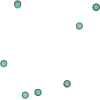

In [21]:
border_crossings = streets.geometry.unary_union.intersection(multiLines)  # streets.intersection(multiLines)
border_crossings

In [22]:
N_subs=1 #Number of biggest islands you want to keep
G_sub=[]
largest_components=[]
for i in range(N_subs):
  largest_components.append(sorted(nx.weakly_connected_components(G_intersection), key=len, reverse=True)[i])
  G_sub.append(G_intersection.subgraph(largest_components[i]))
  
G_cc=nx.compose_all(G_sub)

    ## Construct locations.csv

In [23]:
border_nodes = []
for point in border_crossings.geoms:
    node = ox.nearest_nodes(G_cc, point.x, point.y)
    border_nodes.append(node)

In [24]:
def show_graph_camp(G, border_nodes, cameras):
    edge_colormap, edge_weightmap = draw_edges(G)

    node_size = []
    node_color = []
    
    suspect_start = ox.nearest_nodes(G, -73.98959647256116, 40.73585784808693)  # union square
    
    with open(f'data/optimization/start_police_Manhattan.pkl', 'rb') as f:
        police_start = pickle.load(f)
    
    for node, data in G.nodes(data=True):
        if node in border_nodes:
        # if (round(data['y'], 3) in latlon_y) and (round(data['x'], 3) in latlon_x):
        #     print(data['y'], data['x'])
            node_size.append(80)
            node_color.append('tab:red')
        elif node in police_start:
            node_size.append(80)
            node_color.append('tab:blue')
        elif node == suspect_start: 
            node_size.append(80)
            node_color.append('tab:orange')
        elif node in cameras: 
            node_size.append(20)
            node_color.append('tab:green')
        else:
            node_size.append(0)
            node_color.append('silver')

    fig, ax = ox.plot_graph(
                G, bgcolor="white", node_color=node_color, node_size=node_size, edge_linewidth=edge_weightmap, edge_color=edge_colormap,
                # save=True, filepath=f'graphs/Graph.png'
                )
    fig.savefig('graphs/Manhattan.png', bbox_inches='tight', dpi=300)
    plt.show()

In [25]:
save_graph(G_cc)

In [26]:
import pickle

with open('data/escape_nodes_Manhattan.pkl', 'wb') as f: 
    pickle.dump(border_nodes, f)

suspect_start = ox.nearest_nodes(G, -73.98959647256116, 40.73585784808693)
with open('data/fugitive_start_Manhattan.pkl', 'wb') as f: 
    pickle.dump(suspect_start, f)

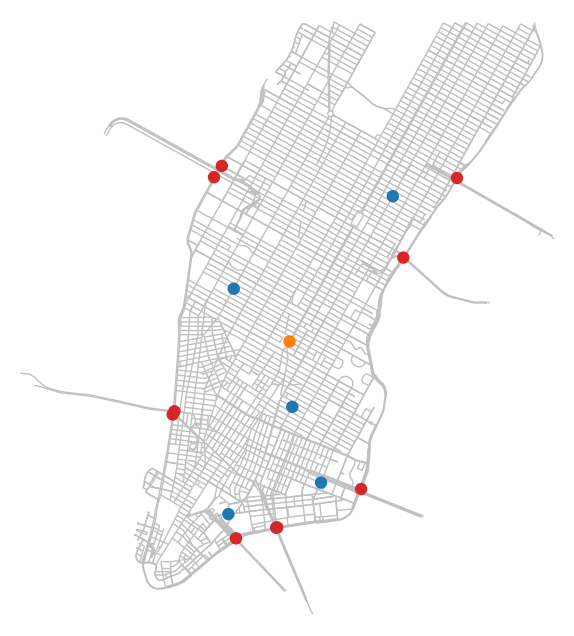

In [40]:
show_graph_camp(G_cc, border_nodes, [])

In [28]:
len(G.nodes())

5987

# Cameras

In [29]:
# intersections = pd.read_csv('data/intersections_MH.csv').set_index('IntersectionId').to_dict()['Lat']
df = pd.read_csv('data/intersections_MH.csv')
intersections_lats = dict(zip(df.IntersectionId, df.Lat))
intersections_lons = dict(zip(df.IntersectionId, df.Long))

intersections = {}
for intersection, lat in intersections_lats.items():
    lon = intersections_lons[intersection]
    intersections[intersection] = {'lat': lat, 'lon': lon}
len(intersections)

45021

In [30]:
cameras_df = pd.read_csv('data/cameras_MH.csv')
# cameras_df = cameras_df.loc[cameras_df['Attached'] == 'building']
cameras_df = cameras_df.loc[cameras_df['Attached'] == 'street_light/traffic_signal/road_sign']
cameras_df

,DecoderId,IntersectionId,SubmissionId,Type,Attached,Createdtime,Id,Title,Pov.heading,Pov.pitch,Pov.zoom,Updatedtime,DecoderGenericId
0,AXjMameVLVwDtjXR1fPz,AXjK_--uLVwDtjXR1ese,camera_mappingHIVEcamera_mapping-camera_mappin...,dome/ptz_camera,street_light/traffic_signal/road_sign,2021-04-26T14:39:16.483Z,0.0,"Dome or PTZ camera on traffic signal, streetli...",249.881974,22.991655,2.772373,NaN,37971.0
1,AXjMameVLVwDtjXR1fPz,AXjK_5g0LVwDtjXR1ekF,camera_mappingHIVEcamera_mapping-camera_mappin...,bullet_camera,street_light/traffic_signal/road_sign,2021-04-26T14:44:25.664Z,0.0,"Bullet camera on traffic signal, streetlight o...",318.964252,3.899176,2.953190,NaN,37971.0
4,AXjMameVLVwDtjXR1fPz,AXjK__SwLVwDtjXR1es9,camera_mappingHIVEcamera_mapping-camera_mappin...,dome/ptz_camera,street_light/traffic_signal/road_sign,2021-04-21T13:49:36.347Z,0.0,"Dome or PTZ camera on traffic signal, streetli...",266.617163,6.124345,2.982837,NaN,37971.0
5,AXjMameVLVwDtjXR1fPz,AXjK__SwLVwDtjXR1es9,camera_mappingHIVEcamera_mapping-camera_mappin...,dome/ptz_camera,street_light/traffic_signal/road_sign,2021-04-21T13:49:41.987Z,1.0,"Dome or PTZ camera on traffic signal, streetli...",264.586228,6.197801,2.982837,NaN,37971.0
10,AXjMameVLVwDtjXR1fPz,AXjLAEBDLVwDtjXR1e0i,camera_mappingHIVEcamera_mapping-camera_mappin...,bullet_camera,street_light/traffic_signal/road_sign,2021-04-21T13:52:47.476Z,2.0,"Bullet camera on traffic signal, streetlight o...",196.636232,3.951466,2.852284,NaN,37971.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
126684,AXn2ye2CgxjkLnQCdup1,AXnkrwf4gxjkLnQCdueW,camera_mappingHIVEcamera_mapping-camera_mappin...,bullet_camera,street_light/traffic_signal/road_sign,2021-06-10T16:40:58.475Z,0.0,"Bullet camera on traffic signal, streetlight o...",159.317336,5.164419,1.000000,NaN,44615.0
126685,AXobtmOULVwDtjXR1kce,AXnkrxQf2iuwklCl-uXp,camera_mappingHIVEcamera_mapping-camera_mappin...,unknown,street_light/traffic_signal/road_sign,2021-06-17T22:28:29.029Z,0.0,"Camera on traffic signal, streetlight or pole",26.431047,11.418644,2.836264,2021-06-17T22:29:22.139Z,45044.0
126686,AXnywBoigxjkLnQCduph,AXnkryDzgxjkLnQCdugN,camera_mappingHIVEcamera_mapping-camera_mappin...,bullet_camera,street_light/traffic_signal/road_sign,2021-06-09T21:54:07.707Z,0.0,"Bullet camera on traffic signal, streetlight o...",333.767943,13.050387,3.955343,NaN,44566.0
126687,AXo_OWMmLVwDtjXR1koD,AXnkryyO2iuwklCl-uY3,camera_mappingHIVEcamera_mapping-camera_mappin...,bullet_camera,street_light/traffic_signal/road_sign,2021-06-24T18:13:46.602Z,0.0,"Bullet camera on traffic signal, streetlight o...",299.861985,14.209366,2.900000,NaN,45349.0


In [31]:
len(list(cameras_df.IntersectionId))

24306

In [32]:
import numpy as np
len(np.unique(list(cameras_df.IntersectionId)))

11074

In [33]:
intersections_iter = intersections.copy()
for intersection in intersections_iter.keys():
    if intersection not in list(cameras_df.IntersectionId):
        del intersections[intersection]
        
len(intersections)

11074

In [34]:
intersections

{'AXjK_--uLVwDtjXR1ese': {'lat': 40.8565628002331, 'lon': -73.8694074001314},
 'AXjK_-5dLVwDtjXR1esV': {'lat': 40.832560000044, 'lon': -73.885379999987},
 'AXjK_-8ULVwDtjXR1esa': {'lat': 40.8444191997863, 'lon': -73.925053799793},
 'AXjK_-ARLVwDtjXR1eq9': {'lat': 40.8860049996311, 'lon': -73.911848000185},
 'AXjK_-DEgxjkLnQCdqYn': {'lat': 40.9022589002281, 'lon': -73.9078336999652},
 'AXjK_-ITLVwDtjXR1erK': {'lat': 40.8564941001227, 'lon': -73.9095932999908},
 'AXjK_-MWLVwDtjXR1erQ': {'lat': 40.8647713999802, 'lon': -73.8018452999206},
 'AXjK_-PlLVwDtjXR1erV': {'lat': 40.8502789996762, 'lon': -73.8980504997307},
 'AXjK_-S5LVwDtjXR1era': {'lat': 40.812408300103, 'lon': -73.9297019997475},
 'AXjK_-ScgxjkLnQCdqY_': {'lat': 40.8676779998399, 'lon': -73.8557070003777},
 'AXjK_-XFLVwDtjXR1erh': {'lat': 40.8792501000121, 'lon': -73.8881455996397},
 'AXjK_-XzLVwDtjXR1eri': {'lat': 40.874549099961, 'lon': -73.8914993001525},
 'AXjK_-ZXLVwDtjXR1erk': {'lat': 40.8556356001029, 'lon': -73.86057130

In [35]:
lats = []
lons = []
for n, data in G.nodes(data=True):
    lats.append(data['y'])
    lons.append(data['x'])

#delete the cameras that are outside the bounding box
intersections_iter = intersections.copy()
for index, data in intersections_iter.items():
    if float(data['lat']) < min(lats) or float(data['lat']) > max(lats):
        del intersections[index]
    elif float(data['lon']) < min(lons)  or float(data['lon']) > max(lons):
        del intersections[index]

In [36]:
len(intersections)

1393

In [37]:
cameras = []

for i, data in intersections.items():
   
    lat = float(data['lat'])
    lon = float(data['lon'])
    closest_node = ox.nearest_nodes(G, lon, lat)
    cameras.append(closest_node)

cameras

[42429340,
 42430068,
 42439563,
 42443027,
 4629486879,
 42438506,
 42438894,
 2348991703,
 42440465,
 42436710,
 42442957,
 3891963915,
 42442961,
 42442963,
 42431659,
 42442983,
 42437445,
 42431681,
 42429693,
 42436489,
 42437436,
 1241820953,
 587987721,
 42448379,
 42451375,
 42443615,
 42432856,
 5542680310,
 42447235,
 6744466013,
 1241820953,
 4629486879,
 1242879136,
 1241820956,
 4143875757,
 42449991,
 42440729,
 42449890,
 42448701,
 588455697,
 42445378,
 42434959,
 3567807957,
 42432451,
 11337295601,
 11337295608,
 42449947,
 42448813,
 42438891,
 7443621689,
 42440463,
 4202908174,
 42436707,
 42430698,
 42433354,
 42430707,
 42430739,
 42430742,
 42453624,
 42430147,
 42427390,
 42436486,
 42450009,
 42436919,
 42427483,
 42429338,
 42451695,
 42437670,
 42423885,
 42437371,
 42449017,
 42455761,
 42452365,
 42430872,
 42454042,
 42446528,
 42421889,
 42455643,
 42431563,
 246580736,
 246579597,
 246579753,
 246580982,
 42431649,
 42429970,
 42455693,
 42429680,
 24

In [38]:
with open('data/cameras_Manhattan.pkl', 'wb') as f: 
    pickle.dump(cameras, f)

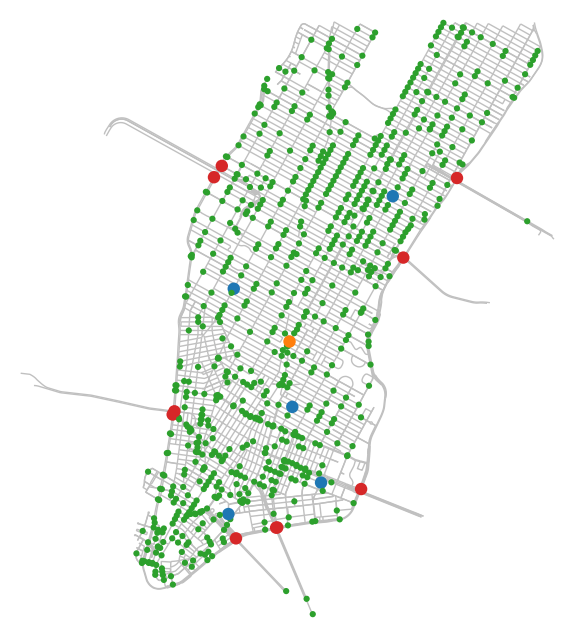

In [39]:
show_graph_camp(G_cc, border_nodes, cameras)